# 08 - Instrumental Variables

## Going Around Omitted Variable Bias

소득에 대한 교육의 인과효과를 알기 위해서는 능력을 통제해야 합니다. 능력은 교육과 소득 모두에 영향을 주는 `confounder`(교란 요인)로 통제하지 않으면 인과효과는 편향됩니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.iv import IV2SLS

%matplotlib inline

pd.set_option("display.max_columns", 5)
style.use("fivethirtyeight")

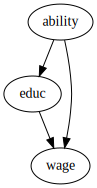

In [2]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g

편향 문제를 해결하는 한 가지 방법은 능력을 일정한 수준으로 통제하는 것입니다. 능력 자체를 모델에 포함할 수 있지만 이를 정량화하기 어렵습니다. 능력을 IQ와 같은 것으로 대체할 수는 있지만 꺼림칙합니다.

여기서 `IV`(`Instrumental Variables`, 도구변수)를 소개합니다. `IV`는 `treatment`에 영향을 주는 변수로 `treatment`를 통해서만 `outcome`을 유발합니다. 즉 `instrument` $Z_i$는 `treatment` $T$에만 연관되며 `outcome` $Y_0$와는 관련이 없습니다. `instrument`가 `treatment`에만 관련 있는 이러한 성질은 `exclusion restriction`라 부릅니다.

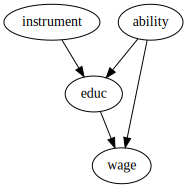

In [3]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("instrument", "educ")
g

`instrument`를 잘 찾는다면 `IV` 공식으로 편향이 제거된 인과효과를 얻을 수 있습니다. 찾고자 하는 이상적인 선형 방정식을 생각해 보겠습니다. 

`treatment` $T$, `confounder` $W$를 포함하는 이상적인 방정식은 아래와 같습니다.

$
Y_i = \beta_0 + \kappa \ T_i + \pmb{\beta}W_i + u_i
$

그러나 $W$에 대한 데이터가 없으므로 다룰 수 있는 방정식은 아래와 같습니다.

$
Y_i = \beta_0 + \kappa\ T_i + v_i
$

$
v_i = \pmb{\beta}W_i + u_i
$

$W$는 교란변수이므로 $Cov(T, v) \neq 0$입니다. 우리의 경우 능력이 $W$에 해당합니다. 짧은 버전의 회귀 분석(아래)으로 인과효과를 추정하면 빠진 $W$ 변수 때문에 인과효과가 편향됩니다.

이제 환상적인 `IV`의 효과를 봅시다! `instrument` `Z`는 `treatment` `T`를 통해서만 `outcome`과 연관되므로 (`confounder` `W`와 관계가 없으므로) $Cov(Z,v) = 0$입니다. 그렇지 않으면 `Z`에서 `W`를 통해 `Y`로 가는 경로가 있을 것이기 때문입니다. 수학적으로는 아래와 같습니다.

$
Cov(Z,Y) = Cov(Z,\beta_0 + \kappa\ T_i + v_i) = \kappa Cov(Z,T) + Cov(Z, v) = \kappa Cov(Z,T)
$

$Z_i$의 분산 $V(Z_i)$로 나누고 정리하면,

$
\kappa = \dfrac{Cov(Y_i, Z_i)/V(Z_i)}{Cov(T_i, Z_i)/V(Z_i)} = \dfrac{\text{Reduced Form}}{\text{1st Stage}} 
$

분자와 분모는 모두 회귀 계수(공분산을 분산으로 나눈 값)입니다. 분자는 `Y`에 대한 `Z`의 계수로 `Y`에 대한 `Z`의 "영향"입니다. `Y`에 대한 `Z`의 영향이 `Z`가 `Y`를 유발한다는 것을 말하려는 것이 아닙니다. (다시 한 번 말하지만 `Z`는 `T`를 통해서만 `Y`에 영향을 줍니다.) 분자항은 단지 `Z`가 `T`를 통해 `Y`에 미치는 영향이 얼마나 큰지 알려줍니다. 분자항은 너무 유명한 나머지 `reduced form`이라는 이름을 갖고 있습니다.

분모는 `T`에 대한 `Z`의 계수입니다. 분모항은 `Z`가 `T`에 미치는 영향으로 `1st Stage`라는 이름으로 불립니다.

방정식을 $z$로 편미분 해보면 `T`가 `Y`에 미치는 영향이 `Z`가 `Y`에 미치는 영향과 같다는 것을 보여줄 수 있습니다.

$
\kappa = \dfrac{\frac{\partial y}{\partial z}}{\frac{\partial T}{\partial z}} = \dfrac{\partial y}{\partial z} * \dfrac{\partial z}{\partial T} =  \dfrac{\partial y}{\partial T}
$

`IV`가 주장하려는 바는 다음과 같습니다. "보세요. `confounder` 때문에 `treatment`의 효과를 찾기 어렵습니다. 다행히도 `exclusion restriction`를 활용하면 `instrument` `Z`가 `outcome` `Y`에 미치는 영향을 쉽게 찾을 수 있습니다. 하지만 저는 `Z`가 아니라 `T`의 영향을 알고 싶어요. 따라서 `Z`가 `Y`에 주는 영향을 추정하고 `T` 단위로 바꾸기 위해 **`T`에 대한 `Z`의 효과로 스케일링할 것입니다.**"

`instrument`가 더미변수인 가장 단순한 예시를 살펴봅시다. 이 경우 `IV`는 두 평균 차이의 비율입니다.

$
\kappa = \dfrac{E[Y|Z=1]-E[Y|Z=0]}{E[T|Z=1]-E[T|Z=0]}
$

이 비율은 **Wald Estimator**라 부릅니다. 정리하자면 알기 어려운 `Y`에 대한 `T`의 효과를 얻기 위해 `IV`를 사용합니다. 먼저 `Z`가 `Y`에 미치는 영향을 얻는 쉬운 작업을 합니다. 정의에 따라 `Z`는 `T`를 통해서만 `Y`에 영향을 주므로 스케일링을 통해 `Z`가 `Y`에 대한 영향을 `T`가 `Y`에 대한 영향으로 바꿀 수 있습니다.

## Quarter of Birth and the Effect of Education on Wage

지금까지 `instrument` `Z`는 `treatment`를 통해서만 `outcome`에 영향을 주는 마법의 변수로 생각해왔습니다. 사실 좋은 `instrument`를 얻는 것은 너무나 어려워서 구하는 것 자체가 기적입니다. 소문에 의하면 시카고 경제 대학의 멋진 술집에서 `instrument`를 처리하는 멋진 아이디어를 알고 있는 듯합니다.

![img](./data/img/iv/good-iv.png)

다시 교육-소득 데이터로 `instrument`에 대한 설명을 구체화해보겠습니다. `instrument` `Z`로 `quarter of birth`(출생분기)를 사용합니다.

`quarter of birth`에 대한 아이디어는 미국의 의무 출석법에서 떠올렸습니다. 미국에서는 1월 1일까지 6살이 되어야 학교에 입학할 수 있습니다. 따라서 연초에 태어난 아이들은 남들보다 더 많은 나이에 학교에 들어가게 됩니다. 또한, 의무 출석법에 따라 학생들은 16살까지 학교에 있어야 하며, 이후 중퇴할 수 있습니다. 결과적으로 연말에 태어난 아이들은 연초에 태어난 아이들보다 평균적으로 더 긴 시간 교육을 받게 됩니다.

![img](./data/img/iv/qob.png)

`quarter of birth`가 능력과 무관하다는 것을 (`confounder`가 아니라는 것을) 믿는다면 `instrument`로 사용할 수 있습니다. `quarter of birth`은 교육 기간에만 영향을 주며 소득과는 무관합니다. 별자리와 같은 미신을 맹신하지 않는 사람에게는 꽤 합리적인 주장입니다.

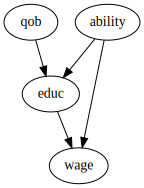

In [4]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("qob", "educ")
g

분석에는 [30년 인구조사 데이터, Angrist and Krueger](https://www.aeaweb.org/articles?id=10.1257/jep.15.4.69)를 사용합니다.

데이터는 `outcome`인 `log_wage`(소득의 로그값), `treatment`인 `years_of_schooling`(교육기간)과 함께 `instrument`인 `quarter_of_birth`(출생분기)를 포함합니다. 추가로 `year_of_birth`(출생연도)와 `state_of_birth`(출생지역) 값을 포함합니다.

In [5]:
data = pd.read_csv("./data/ak91.csv")
data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12.0,30.0,1.0,45.0
1,5.952494,11.0,30.0,1.0,45.0
2,5.315949,12.0,30.0,1.0,45.0
3,5.595926,12.0,30.0,1.0,45.0
4,6.068915,12.0,30.0,1.0,37.0


## The 1st Stage

`quarter_of_birth`를 `instrument`로 사용하기 전에 다음 두 가지 가정을 만족하는지 확인해야 합니다.

1. $Cov(Z, T) \neq 0$. `Z`는 `treatment`에 영향을 주어야 합니다.
2. $Y \perp Z | T $. `Z`는 `T`를 통해서만 `Y`에 영향을 주는 `exclusion restriction`를 만족합니다.

첫 번째 가정은 데이터로 확인할 수 있습니다. $Cov(Z, T) \neq 0$를 보이면 됩니다. `quarter_of_birth`가 `instrument`라면 연말에 태어난 사람은 연초에 태어난 사람보다 약간 더 많은 교육기간을 가져야 합니다. 통계적인 계산 전에 그래프로 데이터를 직접 확인해 보겠습니다.

In [6]:
group_data = (data
              .groupby(["year_of_birth", "quarter_of_birth"])
              [["log_wage", "years_of_schooling"]]
              .mean()
              .reset_index()
              .assign(time_of_birth = lambda d: d["year_of_birth"] + (d["quarter_of_birth"])/4))

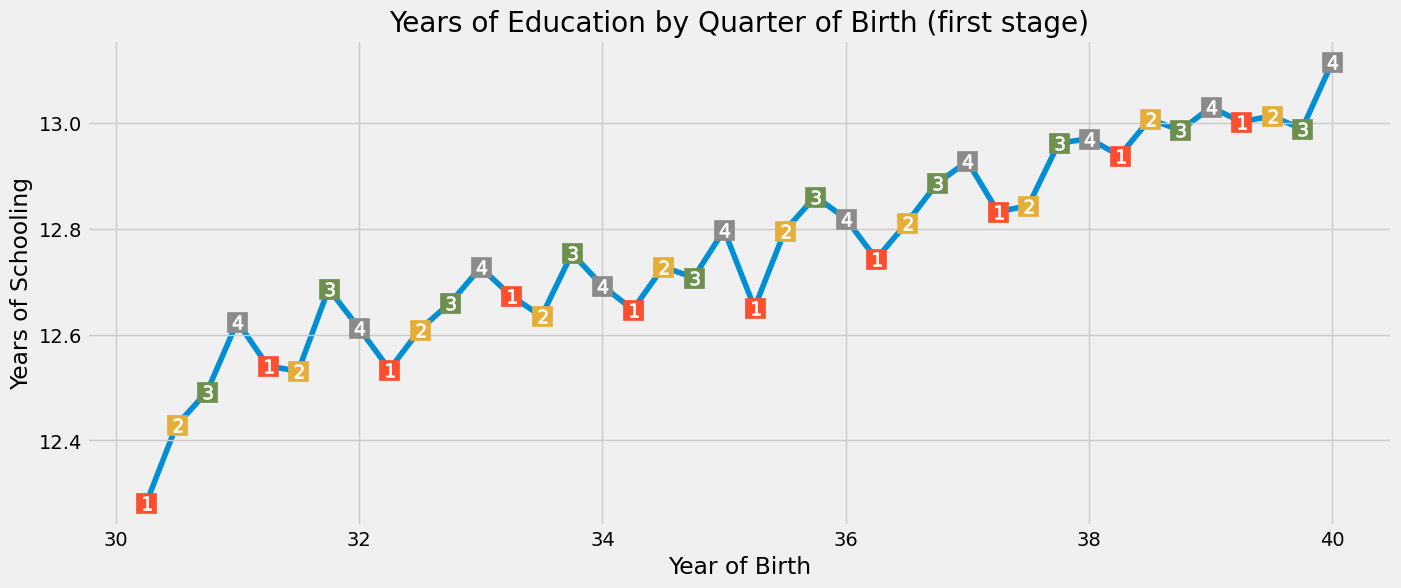

In [7]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["years_of_schooling"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["years_of_schooling"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Years of Education by Quarter of Birth (first stage)")
plt.xlabel("Year of Birth")
plt.ylabel("Years of Schooling");

태어난 해 안에서는 계절적인 패턴(1->2->3->4)이 보입니다. 확실히 연초에 태어난 사람은 연말에 태어난 사람보다 대체로 더 적은 교육을 받습니다. 즉, 출생연도를 통제할 때 일반적으로 연말에 태어난 사람은 더 많은 교육을 받습니다.

`1st stage`는 선형 회귀로 얻습니다. 먼저 `quarter_of_birth`를 더미변수로 바꿉니다.

In [8]:
factor_data = data.assign(**{f"q{int(q)}": (data["quarter_of_birth"] == q).astype(int)
                             for q in data["quarter_of_birth"].unique()})

factor_data.head()

,log_wage,years_of_schooling,...,q3,q4
0,5.790019,12.0,...,0,0
1,5.952494,11.0,...,0,0
2,5.315949,12.0,...,0,0
3,5.595926,12.0,...,0,0
4,6.068915,12.0,...,0,0


지금은 설명을 위해 마지막 분기인 `q4`만 `instrument`로 사용하겠습니다. `years_of_schooling`를 `treatment`, `quarter_of_birth`를 `instrument`로 하여 선형 회귀를 수행합니다. `year_of_birth`와 `state_of_birth`를 통제 변수로 추가합니다. 선형 회귀 결과 `instrument`는 `treatment`에 긍정적으로 영향을 주는 것으로 보입니다.

In [9]:
first_stage = smf.ols("years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", first_stage.params["q4"])
print("q4 p-value:, ", first_stage.pvalues["q4"])

q4 parameter estimate:,  0.10085809272784671
q4 p-value:,  5.464829416641807e-15


마지막 분기에 태어난 사람들은 다른 분기에 태어난 사람들보다 평균적으로 0.1년 긴 교육을 받습니다. `p-value`는 거의 0입니다. 이것으로 `1st stage`에 대한 설명을 마칩니다.

![img](./data/img/iv/incomplete-files.png)

## The Reduced Form

안타깝게도 $Y \perp Z|T$는 확인할 수 없습니다. 그렇다고 믿을 수만 있습니다. 출생분기는 잠재적인 소득에 영향을 주지 않는다고 믿고 가겠습니다. 다시 말해 출생분기는 교육기간에만 영향을 주며 개인적인 능력이나 수입에는 영향을 주지 않습니다. 출생분기는 소득에 대해 무작위 할당만큼 좋습니다. (사실 무작위 할당은 아닙니다. 여름이 끝날 무렵이나 특정 휴가철에 임신을 많이 하는 경향에 대한 증거가 있습니다. 하지만 이러한 패턴이 교육기간이 아닌 다른 방법으로 소득에 영향을 주는 좋은 이유로는 생각되지 않습니다.)

`exclusion restriction`를 만족하므로 `reduced form`를 얻을 수 있습니다. `reduced form`는 `instrument`가 `outcome`에 얼마나 영향을 주는지 계산하는 것을 목표로 합니다. 모든 영향은 `treatment`에 의한 것으로 가정하기 때문에 `instrument`는 `treatment`가 `outcome`에 주는 영향에 대한 근거가 됩니다. 회귀 분석 전에 데이터를 확인해봅시다.

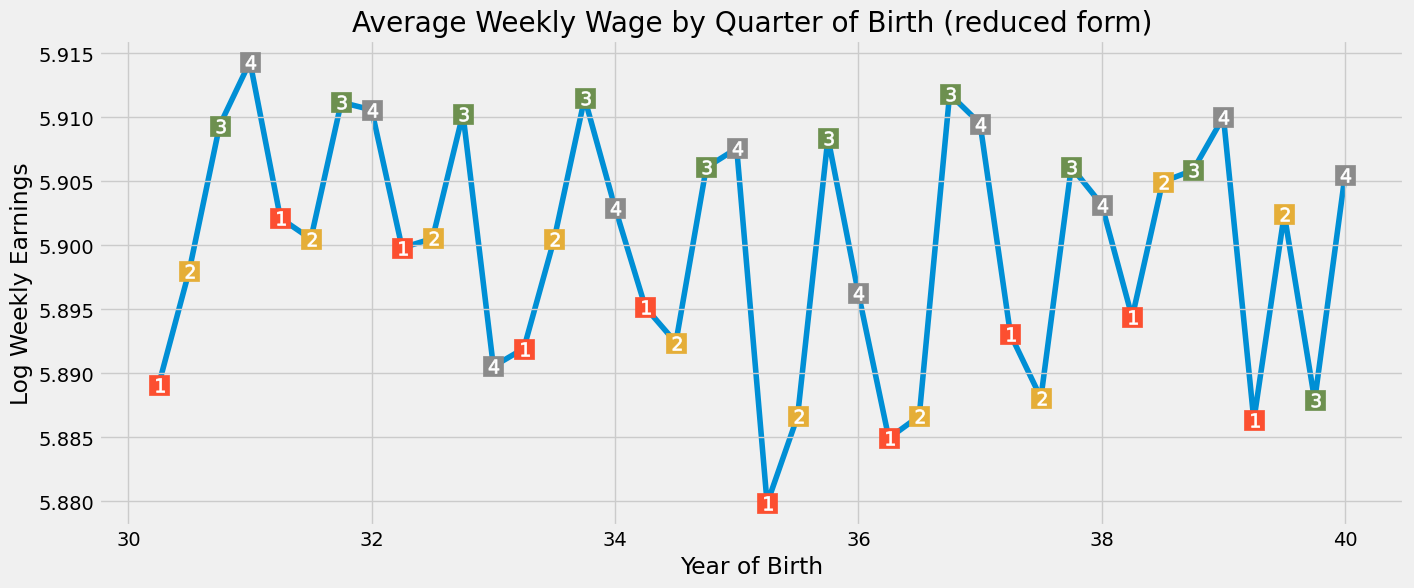

In [10]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["log_wage"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["log_wage"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Average Weekly Wage by Quarter of Birth (reduced form)")
plt.xlabel("Year of Birth")
plt.ylabel("Log Weekly Earnings");

다시 출생분기와 소득의 계절적 패턴(1->2->3->4)이 보입니다. 연초에 태어난 사람들보다 연말에 태어난 사람의 소득이 약간 더 높습니다. 이 가설을 테스트하기 위해 소득의 로그값에 대해 `instrument`인 `q4`의 회귀 식을 만듭니다. 또한, `1st stage`와 같은 `control`을 추가합니다.

In [11]:
reduced_form = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", reduced_form.params["q4"])
print("q4 p-value:, ", reduced_form.pvalues["q4"])

q4 parameter estimate:,  0.008603484260135122
q4 p-value:,  0.0014949127183733534


중요한 결과를 얻었군요! 마지막 분기에 태어난 사람들은 평균적으로 소득이 0.8% 높습니다. `p-value`는 다소 크지만 0.0015에 불과할 정도로 유의합니다.

## Instrumental Variables by Hand

`reduced form`과 `1st stage`를 얻었다면 인과효과인 $kappa$를 얻을 수 있습니다. `1st stage`는 0.1 정도이므로 $kappa$는 `reduced form`의 거의 10배입니다. 이 방법으로 편향되지 않은 $ATE_{IV}$를 얻습니다.

$
ATE_{IV} = \dfrac{\text{Reduced Form}}{\text{1st Stage}} 
$

In [12]:
reduced_form.params["q4"] / first_stage.params["q4"]

0.08530286492082075

$ATE_{IV}$는 교육기간이 1년 늘어날 때마다 소득이 8% 올라갈 것으로 기대한다는 의미입니다.

$ATE_{IV}$를 얻는 또 다른 방법은 2단계 최소 제곱인 **2SLS** 입니다. `1st stage` 이후 `treatment`를 `1st stage`의 예측값으로 대체하는 두 번째 단계를 수행합니다.

$
educ_i = \gamma_0 + \gamma_1 * q4_i + \gamma_2 yob_i + \gamma_3 sob_i + v_i
$

$
log(wage)_i = \beta_0 + \beta_1 educ_i + \beta_2 yob_i + \beta_3 sob_i + u_i
$

$
log(wage)_i = \beta_0 + \beta_1 [\gamma_0 + \gamma_1 * q4_i + \gamma_2 yob_i + \gamma_3 sob_i + v_i ]  + \beta_2 yob_i + \beta_3 sob_i + u_i
$

주의해야 할 점은 **2단계에 사용하는 모든 `control`는 1단계에도 추가해야 한다는 것입니다.**

In [13]:
iv_by_hand = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + years_of_schooling_fitted",
                     data=factor_data.assign(years_of_schooling_fitted=first_stage.fittedvalues)).fit()

iv_by_hand.params["years_of_schooling_fitted"]

0.08530286492081184

두 방법의 결과는 정확히 같습니다. `2SLS`을 직관적으로 이해해봅시다. `2SLS`에서 첫 번째 단계에서는 `omitted variable bias`(생략된 변수 편향)이 제거된 `treatment`를 얻습니다. 그 다음으로 편향이 제거된 `treatment`, 즉 1단계 예측값을 선형 회귀에 사용합니다.

실제로는 코드를 직접 만들어 분석하지는 않습니다. 번거롭기도 하고 두 번째 단계의 표준 오차(`SE`)가 약간 다르기 때문입니다. 대신 잘 만들어진 라이브러리를 사용합니다. Python 라이브러리인 [linearmodels](https://bashtage.github.io/linearmodels/)로 `2SLS`를 올바른 방식으로 사용할 수 있습니다.

2SLS에 포함하는 공식은 약간 다릅니다. `formula` 내 \[\] 사이에 첫 번째 단계를 추가합니다. 우리의 경우 `years_of_schooling ~ q4` 입니다. 두 번째 단계에 `control`을 포함하면 라이브러리가 알아서 첫 번째 단계에도 추가하므로 굳이 첫 번째 단계에 `control`을 명시하지 않아도 됩니다. 그러므로 1단계 회귀 식 외부에 `year_of_birth`와 `state_of_birth`를 추가합니다.

In [14]:
def parse(model, exog="years_of_schooling"):
    param = model.params[exog]
    se = model.std_errors[exog]
    p_val = model.pvalues[exog]
    print(f"Parameter: {param}")
    print(f"SE: {se}")
    print(f"95 CI: {(-1.96*se,1.96*se) + param}")
    print(f"P-value: {p_val}")
    
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]'
iv2sls = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv2sls)

Parameter: 0.08530286486840323
SE: 0.025540812818127933
95 CI: [0.03524287 0.13536286]
P-value: 0.0008381914739772345


다시 한 번 똑같은 결과를 얻었습니다. 라이브러리 사용의 추가적인 이점은 유효한 `SE`(표준 오차)를 얻는다는 점입니다. `SE`를 고려하면 1년의 추가 교육으로 평균 8.5%의 소득이 인상된다고 볼 수 있습니다.

## Multiple Instruments

라이브러리의 또 다른 장점은 다수 `instrument`로 `2SLS`를 수행할 수 있는 것입니다. 예를 들어 모든 분기의 출생분기를 사용할 수 있습니다.

In [15]:
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q1+q2+q3]'
iv_many_zs = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv_many_zs)

Parameter: 0.10769370488287347
SE: 0.019557149010646094
95 CI: [0.06936169 0.14602572]
P-value: 3.657974678716869e-08


`q1`, `q2`, `q3` 3개의 변수를 사용하면 예상되는 교육의 효과는 0.1입니다. 즉, 추가 교육을 받을 때마다 평균 10%의 소득 증가를 기대합니다. 기존의 `OLS` 추정치와 비교해 보겠습니다. 똑같이 `2SLS`를 사용하지만 1단계 공식이 없습니다.

In [16]:
formula = "log_wage ~ years_of_schooling + C(state_of_birth) + C(year_of_birth) + C(quarter_of_birth)"
ols = IV2SLS.from_formula(formula, data=data).fit()
parse(ols)

Parameter: 0.06732572817657712
SE: 0.0003883998439048656
95 CI: [0.06656446 0.06808699]
P-value: 0.0


`OLS`에서 `2SLS`보다 약간 낮은 교육 효과를 보입니다. 이는 `OVB`(`omitted variable bias`)가 강하지 않을 수 있음을 암시합니다. 신뢰 구간에 유의하세요. `2SLS`는 `OLS`보다 `CI`가 훨씬 넓습니다. 이에 대해 자세히 알아보겠습니다.

## Weakness of Instruments

![img](./data/img/iv/weak-iv.png)

`IV`를 다룰 때는 간접적으로 `ATE`를 추정하고 있음을 기억해야 합니다. 1단계와 2단계 모두 추정치에 영향을 줍니다. `treatment`가 `outcome`에 주는 영향이 정말 강하면 2단계 또한 강해집니다. 하지만 1단계가 약하면 2단계가 얼마나 강한지는 중요하지 않습니다. 첫 번째 단계가 약하다는 의미는 `instrument`와 `treatment`의 상관관계가 매우 작음을 의미합니다. 따라서 `instrument`로부터 `treatment`를 알기 어렵습니다.

`IV` 표준 오차 공식은 복잡하고 직관적이지 않으므로 설명을 위해 다른 방법을 시도해 보겠습니다. 

`outcome` `Y`, `omitted confounder` `U`, `control` `X`와 함께 `outcome`에 2.0만큼 효과가 있는 `treatment` `T`를 시뮬레이션합니다. 

또한, 1단계에서 강도가 다른 여러 `instrument`를 만듭니다.

$
X \sim N(0, 2^2)\\
U \sim N(0, 2^2)\\
T \sim N(1+0.5U, 5^2)\\
Y \sim N(2+ X - 0.5U + 2T, 5^2)\\
Z \sim N(T, \sigma^2) \text{ for }\sigma^2 \text{ in 0.1 to 100}
$

In [17]:
np.random.seed(12)
n = 10000
X = np.random.normal(0, 2, n) # observable variable
U = np.random.normal(0, 2, n) # unobservable (omitted) variable
T = np.random.normal(1 + 0.5*U, 5, n) # treatment
Y = np.random.normal(2 + X - 0.5*U + 2*T, 5, n) # outcome

stddevs = np.linspace(0.1, 100, 50)
Zs = {f"Z_{z}": np.random.normal(T, s, n) for z, s in enumerate(stddevs)} # instruments with decreasing Cov(Z, T)

sim_data = pd.DataFrame(dict(U=U, T=T, Y=Y)).assign(**Zs)

sim_data.head()

,U,T,...,Z_48,Z_49
0,2.696148,8.056988,...,-117.798705,-13.485292
1,2.570240,0.245067,...,-209.727577,-70.792948
2,0.664741,5.597510,...,60.562232,47.619414
3,1.037725,0.493532,...,78.136513,-108.322304
4,-2.590591,-6.263014,...,78.776566,-80.547214


`Z`와 `T`의 상관관계가 실제로 줄어들고 있음을 확인할 수 있습니다.

In [18]:
corr = (sim_data.corr()["T"]
        [lambda d: d.index.str.startswith("Z")])

corr.head()

Z_0    0.999807
Z_1    0.919713
Z_2    0.773434
Z_3    0.634614
Z_4    0.523719
Name: T, dtype: float64

이제 각 `instrument` 별로 `IV` 모델을 만들어 `ATE`와 표준 오차를 계산합니다.

In [19]:
se = []
ate = []
for z in range(len(Zs)):
    formula = f'Y ~ 1 + X + [T ~ Z_{z}]'
    iv = IV2SLS.from_formula(formula, sim_data).fit()
    se.append(iv.std_errors["T"])
    ate.append(iv.params["T"])

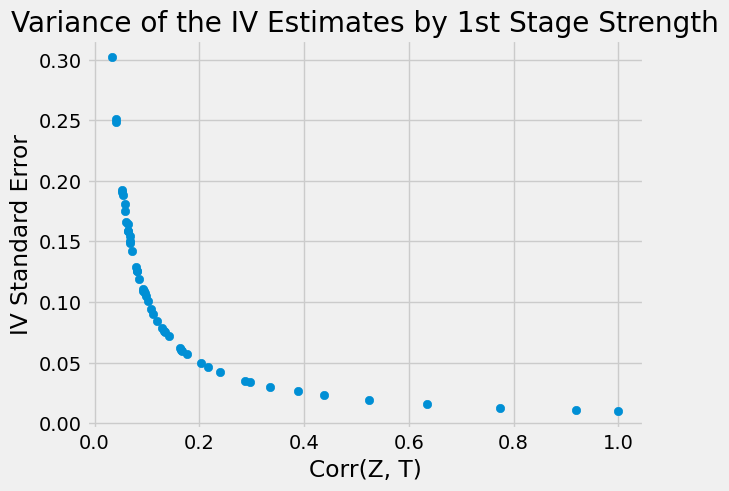

In [20]:
plot_data = pd.DataFrame(dict(se=se, ate=ate, corr=corr)).sort_values(by="corr")

plt.scatter(plot_data["corr"], plot_data["se"])
plt.xlabel("Corr(Z, T)")
plt.ylabel("IV Standard Error");
plt.title("Variance of the IV Estimates by 1st Stage Strength");

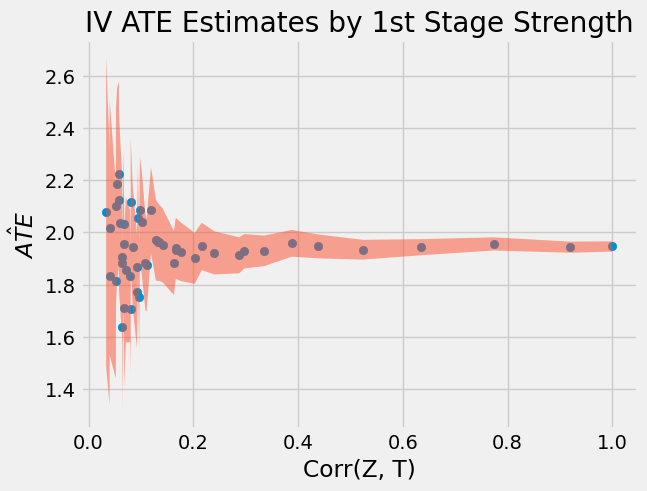

In [21]:
plt.scatter(plot_data["corr"], plot_data["ate"])
plt.fill_between(plot_data["corr"],
                 plot_data["ate"]+1.96*plot_data["se"],
                 plot_data["ate"]-1.96*plot_data["se"], alpha=.5)
plt.xlabel("Corr(Z, T)")
plt.ylabel("$\hat{ATE}$");
plt.title("IV ATE Estimates by 1st Stage Strength");

`T`와 `Z`의 상관관계가 약하면 결과가 크게 달라집니다. 상관관계가 낮으면 `SE`가 증가하기 때문입니다.

그리고 **2SLS가 편향되어 있네요!** 상관관계가 높을 때도 `ATE` 추정치는 실제 `ATE`인 2.0과 다르고 95% CI에도 해당하지 않습니다. `2SLS`는 일관성이 있으므로 데이터가 충분히 크면 실제 `ATE`에 가까워집니다. 하지만 얼마나 많은 데이터가 필요할지는 모릅니다. 편향의 성질을 이해하기 위한 몇 가지 경험칙이 있습니다.

1. `2SLS`는 `OLS` 쪽으로 편향됩니다. 즉, `OLS`에 양/음의 편향이 있다면 `2SLS`도 편향을 갖습니다. `2SLS`의 장점은 `omitted variable`에 대해 일관적이라는 점입니다. (`OLS`는 아닙니다.) 위의 예에서는 `U`가 `Y`에 부정적인 영향을 주지만 `treatment`와는 양의 상관관계가 있어 음의 방향으로 편향이 발생합니다. 따라서 참 값아래에서 `ATE` 추정치가 나타납니다.

2. 추가하는 `instrument` 개수에 따라 편향이 커집니다. `instrument`를 추가할수록 `2SLS`는 점점 `OLS`처럼 됩니다.

마지막 조언은 **IV를 적용할 때 실수하지 않는 방법입니다.**

1. 직접 `IV` 코드를 만들지 마세요. 직접 계산하면 잘못된 표준 오차가 계산됩니다. 라이브러리로 올바른 `SE`를 얻을 수 있으니 잘 만들어진 라이브러리를 사용하세요.

2. `1st stage`에서 `OLS` 이외의 것을 사용하지 마세요. 데이터 과학자는 `instrument`를 접하면 더 잘하려 합니다.예를 들어, 첫 번째 단계에 로지스틱 회귀나 머신러닝을 사용할 수 있습니다. 이 방법이 명백히 잘못되었습니다. `IV`의 일관성은 잔차의 직교성인 `OLS`에 의한 것으로 `OLS`가 아니라면 편향된 결과를 줍니다. (`IV`에 대해 머신러닝을 적용한 연구가 있었지만 타당한지는 의문입니다.)

## Key Ideas

8장에서는 `OVB`(`omitted variable bias`)를 해결하기 위해 `instrument variable`을 사용하는 방법을 공부했습니다. `instrument`는 `treatment`와 상관관계가 있고 (`1st stage`) `treatment`를 통해서만 `outcome`에 영향을 주는 변수입니다 (`exclusion restriction`). 교육이 소득에 미치는 영향을 추정하기 위해 출생분기를 `instrument`로 사용한 예를 살펴보았습니다.

`2SLS`로 인과효과를 추정하는 방법을 배웠습니다. `IV`가 만능은 아니라는 사실도 알게 되었습니다. `1st stage`가 약하면 상당히 번거로워집니다. 또한, `2SLS`는 `OVB`에 대해 일관성이 있지만 편향될 수 있습니다.

## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

![img](./data/img/poetry.png)

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).